# Koopman Kernel Sequencer model

First section (Model training) is about training the model. In the second section (Import trained model) we plot the results of various training settings explored in `train_models/train_koopkernel_sequence.py`.

## Model training

In [ ]:
import random
import numpy as np
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)
from kkseq.koopkernel_sequencer import (
    NystroemKoopKernelSequencer,
    RBFKernel,
)
from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import (
    LinearScaler,
    standardized_context_dataset_from_TCTracks,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.models_utils import get_model_name
from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D
from klearn_tcyclone.koopkernel_sequencer_utils import train_KKSeq2Seq
from klearn_tcyclone.koopkernel_sequencer_utils import plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq
from matplotlib import pyplot as plt

Set some specific parameters and load default values for all other parameters. Other training settings are explored in `train_models/train_koopkernel_sequnce.py`. For a discussion of the parameters `context_mode`, `mask_koopman_operator`, `use_nystroem_context_window` etc. see kkseq repository.

In [ ]:
time_lag = 1
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

tc_tracks_time_step = 3.0


flag_params = {
    "year_range": [2000, 2021],
}
flag_params = extend_by_default_flag_values(flag_params)
# FIXME add context_mode, mask_koopman_operator, mask_version,
#   use_nystroem_context_window to default flat_params parameters

flag_params["batch_size"] = 32
flag_params["num_epochs"] = 10

flag_params["num_steps"] = 1
# FIXME Remove num_steps, not accessed for the KooplearnSequencer.
flag_params["time_step_h"] = tc_tracks_time_step
flag_params["basin"] = "NA"


random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

Import TCTracks dataset

In [ ]:
# Datasets
tc_tracks_dict = get_TCTrack_dict(
    basins=[flag_params["basin"]],
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)
tc_tracks = tc_tracks_dict[flag_params["basin"]]


# train_set is required later for plotting, but not for model training.
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)


Define training setting.

### Single step model

In [13]:
# Set training settings
training_settings = {
    "koopman_kernel_length_scale": [0.24],
    "koopman_kernel_num_centers": [100],
    "context_mode": ["full_context", "last_context"],
    # "context_mode": ["no_context", "full_context", "last_context"],
    "mask_koopman_operator": [True, False],
    "mask_version": [1],
    # "mask_version": [0, 1],
    "use_nystroem_context_window": [False, True],
    "output_length": [1],
}

In [14]:
model_str = "koopkernelseq"
flag_params["model"] = model_str

koopman_kernel_length_scale = training_settings["koopman_kernel_length_scale"][0]
koopman_kernel_num_centers = training_settings["koopman_kernel_num_centers"][0]
context_mode = training_settings["context_mode"][0]
mask_koopman_operator = training_settings["mask_koopman_operator"][0]
mask_version = training_settings["mask_version"][0]
use_nystroem_context_window = training_settings["use_nystroem_context_window"][0]
output_length = training_settings["output_length"][0]

print(
    koopman_kernel_length_scale,
    koopman_kernel_num_centers,
    context_mode,
    mask_koopman_operator,
    mask_version,
    use_nystroem_context_window,
    output_length,
)

if context_mode == "last_context":
    if mask_koopman_operator:
        raise Exception("For context_mode = 'last_context', mask_koopman_operator must be False.")

0.24 100 full_context True 1 False 1


Some additional parameter checks

In [15]:
flag_params["train_output_length"] = output_length
flag_params["test_output_length"] = flag_params["train_output_length"]

flag_params["koopman_kernel_length_scale"] = koopman_kernel_length_scale
flag_params["koopman_kernel_num_centers"] = koopman_kernel_num_centers
flag_params["context_mode"] = context_mode
flag_params["mask_koopman_operator"] = mask_koopman_operator
flag_params["mask_version"] = mask_version
flag_params["use_nystroem_context_window"] = use_nystroem_context_window
if flag_params["context_mode"] == "no_context":
    flag_params["input_length"] = (
        4  # small input_length for context_mode = no_context
    )
    flag_params["input_dim"] = 1
else:
    flag_params["input_length"] = 12
    flag_params["input_dim"] = 4
flag_params["context_length"] = (
    flag_params["input_length"] + flag_params["train_output_length"]
)
assert (
    flag_params["context_length"]
    == flag_params["input_length"] + flag_params["train_output_length"]
)
if flag_params["input_length"] % flag_params["input_dim"] != 0:
    raise Exception("input_length must be divisible by input_dim")

In [ ]:
scaler = LinearScaler()

num_feats = len(feature_list)

eval_metric = RMSE_TCTracks

model_name = get_model_name(flag_params)

rbf = RBFKernel(length_scale=flag_params["koopman_kernel_length_scale"])
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_dim=num_feats,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    output_dim=1,
    num_steps=1,
    num_nys_centers=flag_params["koopman_kernel_num_centers"],
    rng_seed=42,
    context_mode=flag_params["context_mode"],
    mask_koopman_operator=flag_params["mask_koopman_operator"],
    mask_version=flag_params["mask_version"],
    use_nystroem_context_window=flag_params["use_nystroem_context_window"],
)

model, all_train_rmses = train_KKSeq2Seq(
    model=koopkernelmodel,
    eval_metric=eval_metric,
    tc_tracks=tc_tracks,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    feature_list=feature_list,
    scaler=scaler,
    basin=flag_params["basin"],
    flag_params=flag_params,
)


eval comparison 0.13708752239207503 1000000.0
eval comparison 0.12454891004360834 0.13708752239207503
eval comparison 0.11873310389465605 0.12454891004360834
eval comparison 0.11497643583006117 0.11873310389465605
eval comparison 0.11235598901276288 0.11497643583006117
eval comparison 0.11045150238685797 0.11235598901276288
eval comparison 0.1088914807113308 0.11045150238685797
eval comparison 0.10739971301111366 0.1088914807113308
eval comparison 0.10609257145234649 0.10739971301111366
eval comparison 0.10526156422545775 0.10609257145234649


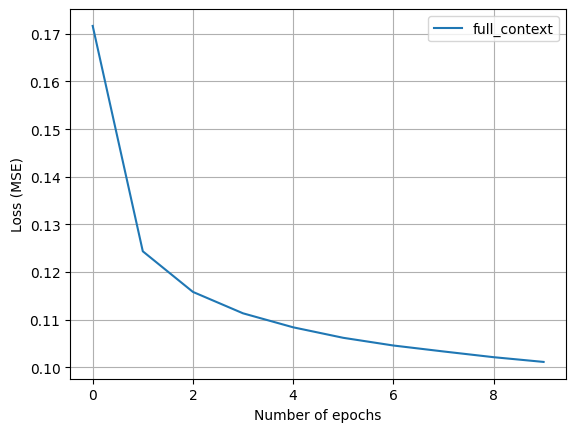

In [18]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), all_train_rmses, color = f"C{0}", label = flag_params["context_mode"])
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

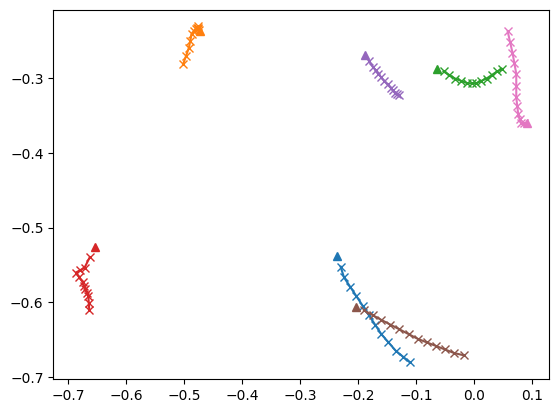

In [19]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])


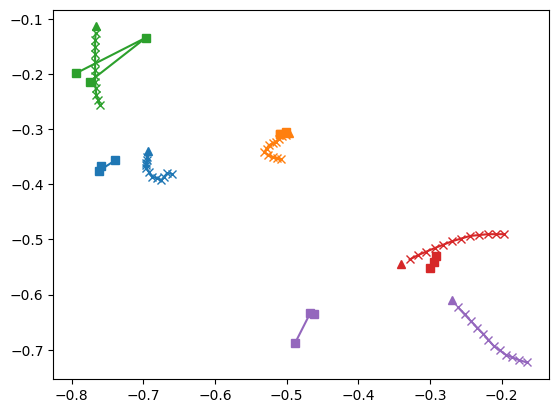

In [20]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

### Multi step model

#### New code

In [125]:
# Set training settings
training_settings = {
    "koopman_kernel_length_scale": [0.24],
    "koopman_kernel_num_centers": [100],
    "context_mode": ["full_context", "last_context"],
    # "context_mode": ["no_context", "full_context", "last_context"],
    "mask_koopman_operator": [True, False],
    "mask_version": [1],
    # "mask_version": [0, 1],
    "use_nystroem_context_window": [False, True],
    "output_length": [2],
}

In [126]:
model_str = "koopkernelseq"
flag_params["model"] = model_str

koopman_kernel_length_scale = training_settings["koopman_kernel_length_scale"][0]
koopman_kernel_num_centers = training_settings["koopman_kernel_num_centers"][0]
context_mode = training_settings["context_mode"][0]
mask_koopman_operator = training_settings["mask_koopman_operator"][1]
mask_version = training_settings["mask_version"][0]
use_nystroem_context_window = training_settings["use_nystroem_context_window"][1]
output_length = training_settings["output_length"][0]

print(
    ("koopman_kernel_length_scale", koopman_kernel_length_scale),
    ("koopman_kernel_num_centers", koopman_kernel_num_centers),
    ("context_mode", context_mode),
    ("mask_koopman_operator", mask_koopman_operator),
    ("mask_version", mask_version),
    ("use_nystroem_context_window", use_nystroem_context_window),
    ("output_length", output_length),
)

if context_mode == "last_context":
    if mask_koopman_operator:
        raise Exception("For context_mode = 'last_context', mask_koopman_operator must be False.")

('koopman_kernel_length_scale', 0.24) ('koopman_kernel_num_centers', 100) ('context_mode', 'full_context') ('mask_koopman_operator', False) ('mask_version', 1) ('use_nystroem_context_window', True) ('output_length', 2)


Some additional parameter checks

In [127]:
flag_params["train_output_length"] = output_length
flag_params["test_output_length"] = flag_params["train_output_length"]

flag_params["koopman_kernel_length_scale"] = koopman_kernel_length_scale
flag_params["koopman_kernel_num_centers"] = koopman_kernel_num_centers
flag_params["context_mode"] = context_mode
flag_params["mask_koopman_operator"] = mask_koopman_operator
flag_params["mask_version"] = mask_version
flag_params["use_nystroem_context_window"] = use_nystroem_context_window
if flag_params["context_mode"] == "no_context":
    flag_params["input_length"] = (
        4  # small input_length for context_mode = no_context
    )
    flag_params["input_dim"] = 1
else:
    flag_params["input_length"] = 12
    flag_params["input_dim"] = 4
flag_params["context_length"] = (
    flag_params["input_length"] + flag_params["train_output_length"]
)
assert (
    flag_params["context_length"]
    == flag_params["input_length"] + flag_params["train_output_length"]
)
if flag_params["input_length"] % flag_params["input_dim"] != 0:
    raise Exception("input_length must be divisible by input_dim")

In [128]:
scaler = LinearScaler()

num_feats = len(feature_list)

eval_metric = RMSE_TCTracks

model_name = get_model_name(flag_params)

rbf = RBFKernel(length_scale=flag_params["koopman_kernel_length_scale"])
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_dim=num_feats,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    output_dim=1,
    num_steps=1,
    num_nys_centers=flag_params["koopman_kernel_num_centers"],
    rng_seed=42,
    context_mode=flag_params["context_mode"],
    mask_koopman_operator=flag_params["mask_koopman_operator"],
    mask_version=flag_params["mask_version"],
    use_nystroem_context_window=flag_params["use_nystroem_context_window"],
)

model, all_train_rmses = train_KKSeq2Seq(
    model=koopkernelmodel,
    eval_metric=eval_metric,
    tc_tracks=tc_tracks,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    feature_list=feature_list,
    scaler=scaler,
    basin=flag_params["basin"],
    flag_params=flag_params,
)



RuntimeError: einsum(): the number of subscripts in the equation (4) does not match the number of dimensions (3) for operand 0 and no ellipsis was given

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)

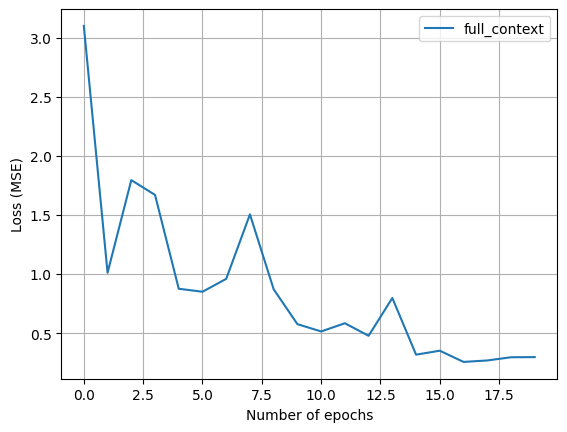

In [ ]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), all_train_rmses, color = f"C{0}", label = flag_params["context_mode"])
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

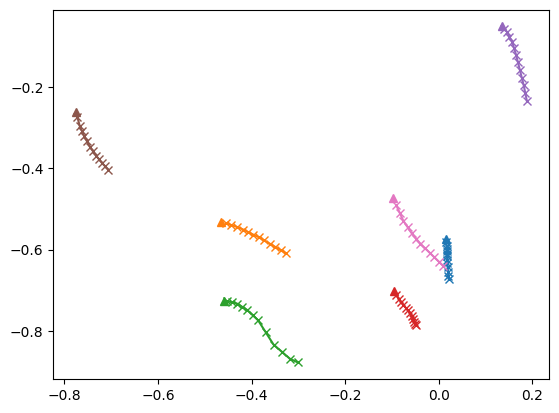

In [ ]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])


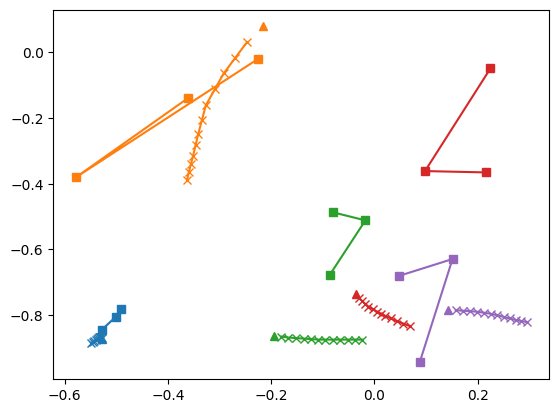

In [ ]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

#### Old code

In [80]:
flag_params["input_length"] = 13
flag_params["train_output_length"] = 5
flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]
flag_params["num_epochs"] = 50
# flag_params["koopman_kernel_num_centers"] = 50
flag_params["koopman_kernel_num_centers"] = 1000

In [81]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

intput_length and output_length are not None.


#### Compare context modes

In [ ]:
# context_modes = [
#     "no_context",
#     "full_context",
#     "last_context",
# ]
# models = {}
# train_losses = {}
# for cm in context_modes:
#     m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
#     models[cm] = m
#     train_losses[cm] = tl


rbf = RBFKernel(length_scale=1E-1)

context_mode = "last_context"
# context_mode = "full_context"
# context_mode = "no_context"

koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_dim = num_feats,
    input_length = flag_params["input_length"],
    output_length = flag_params["train_output_length"],
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    context_mode=context_mode,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


model, train_loss = train_KKSeq2Seq(
    model=koopkernelmodel,
    eval_metric=eval_metric,
    tc_tracks=tc_tracks,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    feature_list=feature_list,
    scaler=scaler,
    basin=basin,
    flag_params=flag_params,
    log_file_handler=fileHandler,
    results_dir=results_dir,
    model_name=model_name,
    split_valid_set = False,
)

torch.Size([1000, 5]) torch.Size([1000, 5])
range(0, 94)
  batch 10 loss: 0.4492741316556931
  batch 20 loss: 0.2319808378815651
  batch 30 loss: 0.11231947094202041
  batch 40 loss: 0.07032168060541152
  batch 50 loss: 0.0663390163332224
  batch 60 loss: 0.052049097046256064
  batch 70 loss: 0.055054842680692676
  batch 80 loss: 0.0369167847558856
  batch 90 loss: 0.03742564171552658
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 94)
  batch 10 loss: 0.03486640602350235
  batch 20 loss: 0.03213535193353891
  batch 30 loss: 0.02332946062088013
  batch 40 loss: 0.021954132243990898
  batch 50 loss: 0.027205750904977323
  batch 60 loss: 0.025441078934818506
  batch 70 loss: 0.031246060132980348
  batch 80 loss: 0.022924530878663064
  batch 90 loss: 0.028894935548305512
{'lr': 0.0009000000000000001, 'betas': 

In [87]:
train_loss

[0.03742564171552658,
 0.028894935548305512,
 0.026346487738192082,
 0.02542712166905403,
 0.024877582490444184,
 0.0182928285561502,
 0.012673718249425292,
 0.010342279309406876,
 0.008692035917192698,
 0.008351310202851892,
 0.009006814262829722,
 0.012452550837770105,
 0.006446364079602062,
 0.006057468452490866,
 0.0059493490727618335,
 0.005976478941738606,
 0.008881823113188147,
 0.005688745249062777,
 0.006159429065883159,
 0.005144059960730374,
 0.004538535559549928,
 0.0043784511974081395,
 0.004299299069680273,
 0.00417413174873218,
 0.004032243485562503,
 0.003929367510136217,
 0.0038489003316499295,
 0.003754794003907591,
 0.00368600282818079,
 0.003625546267721802,
 0.003566568612586707,
 0.0035117162740789356,
 0.003460326394997537,
 0.003413498983718455,
 0.00337375063681975,
 0.0033386012190021576,
 0.0033034726278856398,
 0.0032682946417480706,
 0.0032346159452572463,
 0.0032045458909124138,
 0.003179080761037767,
 0.0031571053550578654,
 0.003137594787403941,
 0.00311

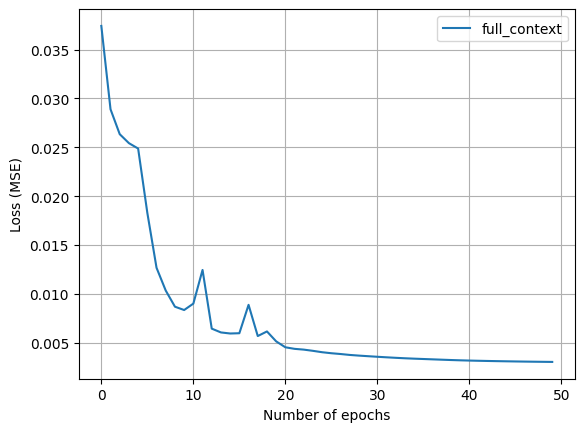

In [88]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), train_loss, color = f"C{0}", label = "full_context")
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

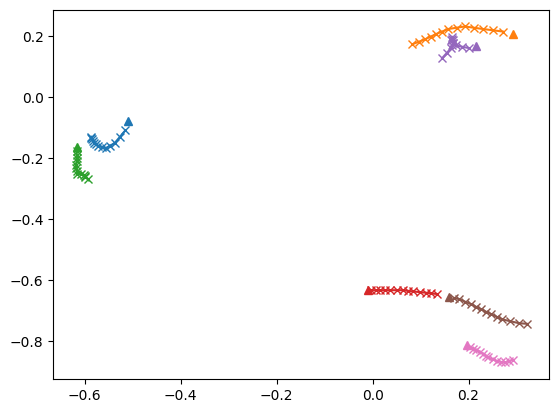

In [71]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])


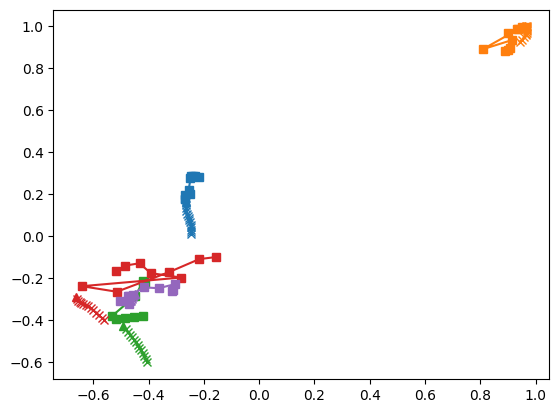

In [78]:
prediction_steps = 10

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

## Import trained model

Training of the model for different architectures and training settings is done in `train_models/train_koopkernel_sequence.py`. We plot the results below.

In [1]:
import os
import random
from matplotlib import pyplot as plt
from itertools import product

import numpy as np
import torch

# from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.models_utils import get_model_name
from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

Setting parameters

In [2]:
time_lag = 1
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]


# Set training settings
training_settings = {
    # "koopman_kernel_length_scale": [0.06, 0.08, 0.1, 0.12, 0.14],
    "koopman_kernel_length_scale": [0.16, 0.18, 0.20, 0.22, 0.24],
    "koopman_kernel_num_centers": [1000],
    "context_mode": ["full_context", "last_context"],
    # "context_mode": ["no_context", "full_context", "last_context"],
    "mask_koopman_operator": [True, False],
    "mask_version": [1],
    # "mask_version": [0, 1],
    "use_nystroem_context_window": [False, True],
    "output_length": [1],
}


tc_tracks_time_step = 3.0
flag_params = {
    "year_range": [2000, 2021],
}
flag_params = extend_by_default_flag_values(flag_params)
# FIXME add context_mode, mask_koopman_operator, mask_version,
#   use_nystroem_context_window to default flat_params parameters

flag_params["batch_size"] = 32
# flag_params["num_epochs"] = 10
flag_params["num_epochs"] = 100

flag_params["num_steps"] = 1
# FIXME Remove num_steps, not accessed for the KooplearnSequencer.
flag_params["time_step_h"] = tc_tracks_time_step
flag_params["basin"] = "NA"


random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator


current_file_dir_path = os.getcwd()



Import data:

We import data from the KNF training and the Koopman Kernel Sequencer training, to compare both models on the given tropical cyclone dataset.

In [3]:
res_dict = {}
model_strings = ["koopkernelseq"]
for model_str in model_strings:
    print()
    print("===================================")
    print(f"Load data for {model_str}.")
    print("===================================")
    print()

    flag_params["model"] = model_str

    results_dir = os.path.join(
        current_file_dir_path,
        "../train_models/training_results",
        "comparison_knf_koopkernel_seq",
        "{}_yrange{}_basin{}_tstep{}".format(
            flag_params["dataset"],
            "".join(map(str, flag_params["year_range"])),
            flag_params["basin"],
            flag_params["time_step_h"],
        ),
        flag_params["model"],
        "parameter_search_lls",
    )

    for (
        koopman_kernel_length_scale,
        koopman_kernel_num_centers,
        context_mode,
        mask_koopman_operator,
        mask_version,
        use_nystroem_context_window,
        output_length,
    ) in product(*training_settings.values()):
        # print()
        # print()
        # print("=============================================================")
        # print("Iteration:")
        # print(
        #     koopman_kernel_length_scale,
        #     koopman_kernel_num_centers,
        #     context_mode,
        #     mask_koopman_operator,
        #     mask_version,
        #     use_nystroem_context_window,
        #     output_length,
        # )
        if context_mode == "last_context":
            if mask_koopman_operator:
                # print("Skip iteration.")
                continue

        flag_params["train_output_length"] = output_length
        flag_params["test_output_length"] = flag_params["train_output_length"]

        flag_params["koopman_kernel_length_scale"] = koopman_kernel_length_scale
        flag_params["koopman_kernel_num_centers"] = koopman_kernel_num_centers
        flag_params["context_mode"] = context_mode
        flag_params["mask_koopman_operator"] = mask_koopman_operator
        flag_params["mask_version"] = mask_version
        flag_params["use_nystroem_context_window"] = use_nystroem_context_window
        if flag_params["context_mode"] == "no_context":
            flag_params["input_length"] = (
                4  # small input_length for context_mode = no_context
            )
            flag_params["input_dim"] = 1
        else:
            flag_params["input_length"] = 12
            flag_params["input_dim"] = 4
        flag_params["context_length"] = (
            flag_params["input_length"] + flag_params["train_output_length"]
        )
        assert (
            flag_params["context_length"]
            == flag_params["input_length"] + flag_params["train_output_length"]
        )
        if flag_params["input_length"] % flag_params["input_dim"] != 0:
            raise Exception("input_length must be divisible by input_dim")

        model_name = get_model_name(flag_params)

        res_dict[
            (
                koopman_kernel_length_scale,
                koopman_kernel_num_centers,
                context_mode,
                mask_koopman_operator,
                mask_version,
                use_nystroem_context_window,
                output_length,
            )
        ] = torch.load(
            # {
            #     "test_preds": test_preds,
            #     "test_tgts": test_tgts,
            #     "eval_score": eval_metric(
            #         test_preds, test_tgts
            #     ),  # FIXME eval_metric() here is a tuple of four elements, why? Should be a single number.
            #     "train_rmses": all_train_rmses,
            #     "eval_rmses": all_eval_rmses,
            #     "training_runtime": training_runtime,
            # },
            os.path.join(results_dir, "test_" + model_name + ".pt"),
            weights_only=False,
        )


print()
print("===================================")
print(f"Load data for KNF.")
print("===================================")
print()

flag_params["model"] = "KNF"
model_name = get_model_name(flag_params)
time_stamp = "2025-03-19-18-11-38"
results_dir = os.path.join(
    current_file_dir_path,
    "../train_models/training_results",
    "comparison_knf_koopkernel_seq",
    "{}_yrange{}_basin{}_tstep{}".format(
        flag_params["dataset"],
        "".join(map(str, flag_params["year_range"])),
        flag_params["basin"],
        flag_params["time_step_h"],
    ),
    flag_params["model"],
    time_stamp,
)

res_dict_knf = torch.load(
    # {
    #     "test_preds": test_preds,
    #     "test_tgts": test_tgts,
    #     "eval_score": eval_metric(
    #         test_preds, test_tgts
    #     ),  # FIXME eval_metric() here is a tuple of four elements, why? Should be a single number.
    #     "train_rmses": all_train_rmses,
    #     "eval_rmses": all_eval_rmses,
    #     "training_runtime": training_runtime,
    # },
    os.path.join(results_dir, "test_" + model_name + ".pt"),
    weights_only=False,
)




Load data for koopkernelseq.


Load data for KNF.



Plotting

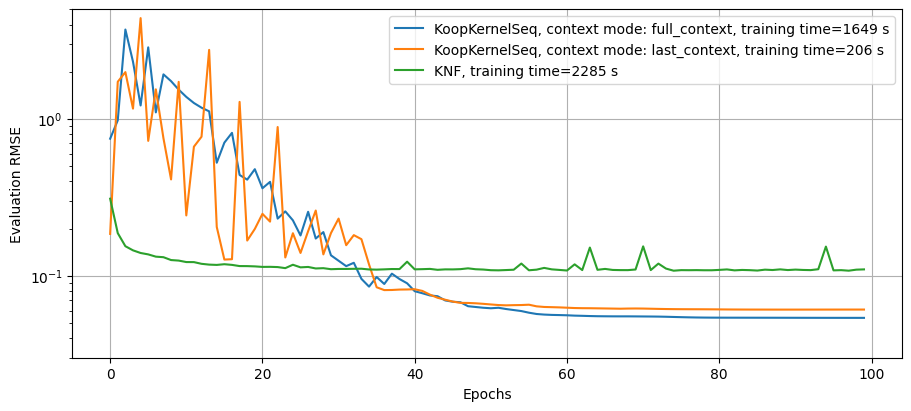

In [4]:
plot_settings = {
    "koopman_kernel_length_scale": [0.24],
    "koopman_kernel_num_centers": [1000],
    "context_mode": ["full_context", "last_context"],
    "mask_koopman_operator": [False],
    "mask_version": [1],
    # "mask_version": [0, 1],
    "use_nystroem_context_window": [True],
    "output_length": [1],
}

nrows = len(
    list(
        product(
            plot_settings["mask_koopman_operator"],
            plot_settings["use_nystroem_context_window"],
        )
    )
)

fig, ax = plt.subplots(nrows=1, ncols=1, layout="constrained")
fig.set_size_inches(9, 4)

koopman_kernel_num_centers = plot_settings["koopman_kernel_num_centers"][0]
mask_version = plot_settings["mask_version"][0]
output_length = plot_settings["output_length"][0]
mask_koopman_operator = plot_settings["mask_koopman_operator"][0]
use_nystroem_context_window = plot_settings["use_nystroem_context_window"][0]
koopman_kernel_length_scale = plot_settings["koopman_kernel_length_scale"][0]


context_mode = plot_settings["context_mode"][0]
conf = (
    koopman_kernel_length_scale,
    koopman_kernel_num_centers,
    context_mode,
    mask_koopman_operator,
    mask_version,
    use_nystroem_context_window,
    output_length,
)
y = res_dict[conf]["eval_rmses"]
ymin = np.min(y)
x = range(len(y))
ax.plot(
    x,
    y,
    color=f"C{0}",
    label=f"KoopKernelSeq, context mode: {context_mode}, training time={res_dict[conf]['training_runtime']:.0f} s",
    # label=f"KoopKernelSeq, context mode: {context_mode}, ymin={ymin:.3f}, rt={res_dict[conf]['training_runtime']:.2f}",
)
# y = res_dict[conf]["train_rmses"]
# ax.plot(
#     x,
#     y,
#     color=f"C{0}",
#     linestyle="dashed",
# )

context_mode = plot_settings["context_mode"][1]
conf = (
    koopman_kernel_length_scale,
    koopman_kernel_num_centers,
    context_mode,
    mask_koopman_operator,
    mask_version,
    use_nystroem_context_window,
    output_length,
)
y = res_dict[conf]["eval_rmses"]
ymin = np.min(y)
x = range(len(y))
ax.plot(
    x,
    y,
    color=f"C{1}",
    label=f"KoopKernelSeq, context mode: {context_mode}, training time={res_dict[conf]['training_runtime']:.0f} s",
    # label=f"KKS, CM={context_mode}, ymin={ymin:.3f}, rt={res_dict[conf]['training_runtime']:.2f}",
)
# y = res_dict[conf]["train_rmses"]
# ax.plot(
#     x,
#     y,
#     color=f"C{1}",
#     linestyle="dashed",
# )


y = res_dict_knf["eval_rmses"]
ymin = np.min(y)
x = range(len(y))
ax.plot(
    x,
    y,
    color=f"C{2}",
    label=f"KNF, training time={res_dict_knf['training_runtime']:.0f} s",
    # label=f"KNF, ymin={ymin:.3f}, rt={res_dict_knf['training_runtime']:.2f}",
)
# y = res_dict_knf["train_rmses"]
# ax.plot(
#     x,
#     y,
#     color=f"C{2}",
#     linestyle="dashed",
# )

ax.set_xlabel("Epochs")
ax.set_ylabel("Evaluation RMSE")
ax.set_ylim(3e-2, 5e0)
ax.set_yscale("log")
ax.grid()
ax.legend()


# fig.savefig("knf_vs_KoopKernelSequencer.pdf")


The Koopman Kernel Sequencer outperforms the KNF model, both in terms of RMSE and in terms of training runtime. Using `context_mode = last_context` significantly reduces training runtime, while maintaining very good RMSE values (clearly below KNF).